In [1]:
t_delta = 0.01

# Golden dynamics visualization

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

default_dir = os.path.dirname(os.getcwd())
os.chdir(default_dir)
import RLConn as rc
from RLConn import problem_definitions as problems
from RLConn import connectome_utils as connectome_utils

problem = problems.THREE_NEURON_OSCILLATION
m1_target = problem.m1_target
m2_target = problem.m2_target

/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephen/anaconda3/envs/rl




Instructions for updating:
Use keras.layers.dense instead.


/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephen/anaconda3/envs/rlconn-env/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/step

In [3]:
print("Shapes of m1 and m2: %s, %s" % (m1_target.shape, m2_target.shape))

Shapes of m1 and m2: (500,), (500,)


Text(0.5, 0.98, 'Golden dynamics')

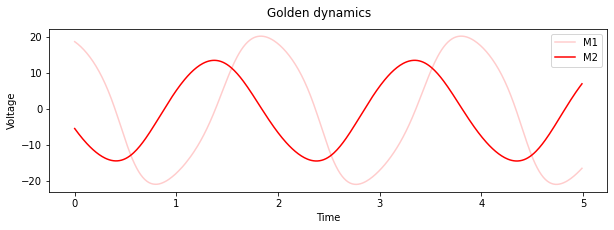

In [4]:
num_timesamples = m1_target.shape[0]

timepoints = np.arange(0, num_timesamples * t_delta, t_delta)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(timepoints, m1_target, label="M1", c ="red", alpha =0.2)
ax.plot(timepoints, m2_target, label="M2", c ="red", alpha= 1.0)
ax.set_xlabel("Time")
ax.set_ylabel("Voltage")
ax.legend()
fig.suptitle("Golden dynamics")

# Initial unoptimized connectome

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 30.4251, Summed error  = 15212.5534


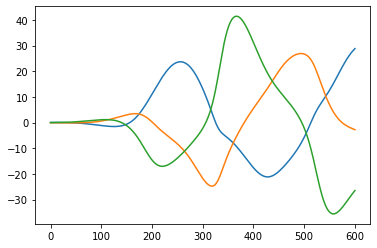

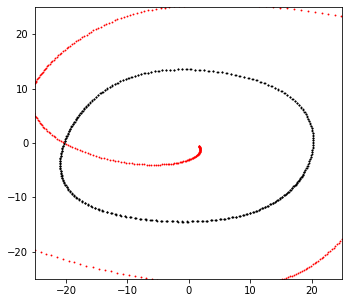

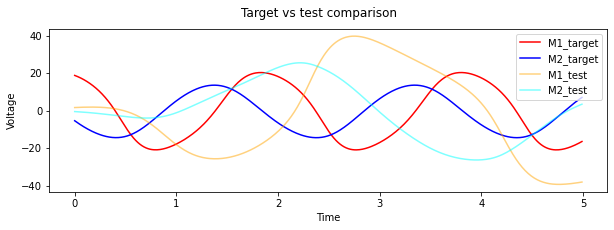

In [6]:
from RLConn import stephen_utils as connectomes

N = problem.N
initial_network = connectome_utils.generate_random_network(
  N = N,
  n_inhibitory = 1,
  max_degree = 15)

# + np.random.rand(num_gg_compact(N) + num_gs_compact(N))
init_compact_vec = [8, 5, 2, 7, 7, 7, 2, 8, 3] 
init_Gg, init_Gs = connectomes.compact_to_model_param(init_compact_vec, N)

mean_err, summed_err = rc.utils.compute_problem_score(init_Gg, init_Gs, problem, verbose=False)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))

# Perform optimization

In [7]:
eval_times = []
errs = []
num_called = 0
min_err = 1000000
def obj_fun(compact_vec):
  global num_called
  global min_err
  global init_Gg
  global init_Gs
  global eval_times
  global errors
  num_called += 1
  gg_mat, gs_mat = connectomes.compact_to_model_param(compact_vec, N)
  mean_err, summed_err = rc.utils.compute_problem_score(gg_mat, gs_mat, problem,
                                                        plot_result=False, verbose=False)
  # TODO: Train on summed_err or mean?
  err = summed_err
  min_err = min(min_err, err)
  if num_called % 10 == 0:
    print("Evaluation %s, error = %.2f, min_error = %.2f" % (num_called, err, min_err))
    print("Gg = " + str(gg_mat))
    print("Gs = " + str(gs_mat))
    print("delta Gg = " + str((init_Gg - gg_mat).round(2)))
    print("delta Gs = " + str((init_Gs - gs_mat).round(2)))
    eval_times.append(num_called)
    errs.append(err)
  return err

In [8]:
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import time

N = problem.N
init_cond_compact = connectomes.model_to_compact_param(init_Gg, init_Gs, N)
bnds = [(0, 10)] * len(init_cond_compact)

"""
These methods are discarded:
Doesn't handle bounds. Documentation says: L-BFGS-B, TNC, SLSQP and trust-constr 
- BFGS 
- Powell 
- Nelder-Mead
"""

# See the options from here
# https://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.optimize.show_options.html
def optimize_with_SLSQP():
  return minimize(obj_fun, init_cond_compact, method='SLSQP', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_L_BFGS_B():
  return minimize(obj_fun, init_cond_compact, method='L-BFGS-B', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_TNC():
  return minimize(obj_fun, init_cond_compact, method='TNC', bounds=bnds,
                  options={'maxiter':10})

def optimize_with_trust_constr():
  return minimize(obj_fun, init_cond_compact, method='trust-constr', bounds=bnds,
                  options={'maxiter':100})

def optimize_with_basin_hopping():
  minimizer_kwargs = {"method":"Powell", "bounds":bnds}
  # You can add niter=k to limit the number of bruteforces
  return basinhopping(obj_fun, init_cond_compact, minimizer_kwargs=minimizer_kwargs)
  
start_time = time.time()
res = optimize_with_trust_constr()
print("Total optimization time = %.2fs" % (time.time() - start_time))
print(res)

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 90, error = 15158.22, m

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 130, error = 15237.65, min_error = 14950.02
Gg = [[0.         7.97733747 4.93669055]
 [7.97733747 0.         1.94877838]
 [4.93669055 1.94877838 0.        ]]
Gs = [[0.         2.01678876 7.48670553]
 [6.9327091  0.         3.09136124]
 [7.10950433 7.01688123 0.        ]]
delta Gg = [[0.   0.02 0.06]
 [0.02 0.   0.05]
 [0.06 0.05 0.  ]]
delta G

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 170, error = 15255.29, min_error = 14950.02
Gg = [[0.         7.97722026 4.93696138]
 [7.97722026 0.         1.94823303]
 [4.93696138 1.94823303 0.        ]]
Gs = [[0.         2.01737597 7.48713787]
 [6.93318158 0.         3.09132899]
 [7.10970494 7.0169598  0.        ]]
delta Gg = [[0.   0.02 0.06]
 [0.02 0.   0.05]
 [0.06 0.05 0.  ]]
delta Gs = [[ 0.   -0.02  0.51]
 [ 0.07  0.   -0.09]
 [-0.11 -0.02  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy


Network integration prep completed...
Computing network dynamics...
Evaluation 210, error = 15218.81, min_error = 14950.02
Gg = [[0.         7.97721207 4.93694779]
 [7.97721207 0.         1.94817777]
 [4.93694779 1.94817777 0.        ]]
Gs = [[0.         2.01738547 7.48715048]
 [6.9332124  0.         3.0913409 ]
 [7.10970754 7.01695801 0.        ]]
delta Gg = [[0.   0.02 0.06]
 [0.02 0.   0.05]
 [0.06 0.05 0.  ]]
delta Gs = [[ 0.   -0.02  0.51]
 [ 0.07  0.   -0.09]
 [-0.11 -0.02  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 300, error = 14952.54, 

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 340, error = 15109.76, min_error = 14863.13
Gg = [[0.         7.99228184 4.86001947]
 [7.99228184 0.         1.99388064]
 [4.86001947 1.99388064 0.        ]]
Gs = [[0.         2.011808

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 380, error = 14934.23, min_error = 14863.13
Gg = [[0.         7.98816067 4.84602818]
 [7.98816067 0.         2.01058907]
 [4.84602818 2.01058907 0.        ]]
Gs = [[0.         2.00184728 7.47975693]
 [6.79276703 0.         2.93820064]
 [7.03467446 6.96489581 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 420, error = 14864.20, min_error = 14862.70
Gg = [[0.         7.98731554 4.8465133 ]
 [7.98731554 0.         2.01022182]
 [4.8465133  2.01022182 0.        ]]
Gs = [[0.         2.00138336 7.47851931]
 [6.79299093 0.         2.93700719]
 [7.03814862 6.96324462 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.04  0.04  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 460, error = 15122.49, min_error = 14862.70
Gg = [[0.         7.98730062 4.84647281]
 [7.98730062 0.         2.01019427]
 [4.84647281 2.01019427 0.        ]]
Gs = [[0.         2.00138272 7.47848667]
 [6.79293547 0.         2.93686585]
 [7.03836406 6.96317473 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.04  0.04  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 500, error = 14864.05, min_error = 14860.47
Gg = [[0.         7.98729998 4.84647117]
 [7.98729998 0.         2.01018921]
 [4.84647117 2.01018921 0.        ]]
Gs = [[0.         2.00138488 7.47848678]
 [6.79293418 0.         2.9368608 ]
 [7.03837102 6.96317339 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.04  0.04  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Network integration prep completed...
Computing network dynamics...
Evaluation 540, error = 14861.94, min_error = 14860.47
Gg = [[0.         7.98729991 4.84647104]
 [7.98729991 0.         2.01018941]
 [4.84647104 2.01018941 0.        ]]
Gs = [[0.         2.00138483 7.47848668]
 [6.79293431 0.         2.93686038]
 [7.03837066 6.96317327 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.04  0.04  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the defaul

Evaluation 580, error = 14861.09, min_error = 14860.47
Gg = [[0.         7.9872999  4.84647098]
 [7.9872999  0.         2.01018906]
 [4.84647098 2.01018906 0.        ]]
Gs = [[0.         2.001385   7.47848666]
 [6.79293414 0.         2.93686035]
 [7.03837094 6.96317348 0.        ]]
delta Gg = [[ 0.    0.01  0.15]
 [ 0.01  0.   -0.01]
 [ 0.15 -0.01  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.04  0.04  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 710, error = 15030.97, min_error = 14835.29
Gg = [[0.         7.96840638 4.84977879]
 [7.96840638 0.         2.01515

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 750, error = 15031.55, min_error = 14835.29
Gg = [[0.         7.96841014 4.85003104]
 [7.96841014 0.         2.01504547]
 [4.85003104 2.01504547 0.        ]]
Gs = [[0.         2.00239377 7.48218124]
 [6.79068001 0.         2.94262034]
 [7.03030205 6.96502946 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 790, error = 15069.57, min_error = 14798.21
Gg = [[0.         7.96841544 4.85005085]
 [7.96841544 0.         2.01505567]
 [4.85005085 2.01505567 0.        ]]
Gs = [[0.         2.00238826 7.48219273]
 [6.79069887 0.         2.94263544]
 [7.03033388 6.96504629 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 830, error = 14906.09, min_error = 14774.79
Gg = [[0.         7.96841095 4.85004458]
 [7.96841095 0.         2.01505358]
 [4.85004458 2.01505358 0.        ]]
Gs = [[0.         2.00238783 7.48218725]
 [6.79069158 0.         2.94263001]
 [7.03032464 6.96503875 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Evaluation 870, error = 14784.29, min_error = 14774.45
Gg = [[0.         7.96841131 4.85004649]
 [7.96841131 0.         2.01505399]
 [4.85004649 2.01505399 0.        ]]
Gs = [[0.         2.0023869  7.48218793]
 [6.79069217 0.         2.94263146]
 [7.03032685 6.96504038 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1040, error = 14968.37, min_error = 14774.45
Gg = [[0.         7.96841491 4.85004113]
 [7.96841491 0.         2.01505333]
 [4.85004113 2.01505333 0.        ]]
Gs = [[0.         2.00238

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1080, error = 14991.52, min_error = 14774.45
Gg = [[0.         7.96841127 4.85004472]
 [7.96841127 0.         2.01505416]
 [4.85004472 2.01505416 0.        ]]
Gs = [[0.         2.00238668 7.48218725]
 [6.79069176 0.         2.9426319 ]
 [7.03032635 6.96504097 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons ar

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Evaluation 1120, error = 14794.21, min_error = 14774.45
Gg = [[0.         7.96841128 4.85004652]
 [7.96841128 0.         2.01505404]
 [4.85004652 2.01505404 0.        ]]
Gs = [[0.         2.00238672 7.48218758]
 [6.79069208 0.         2.94263174]
 [7.03032686 6.96504063 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons ar

Evaluation 1160, error = 14916.86, min_error = 14774.45
Gg = [[0.         7.96841137 4.85004663]
 [7.96841137 0.         2.01505408]
 [4.85004663 2.01505408 0.        ]]
Gs = [[0.         2.00238675 7.48218796]
 [6.79069223 0.         2.94263172]
 [7.03032713 6.96504055 0.        ]]
delta Gg = [[ 0.    0.03  0.15]
 [ 0.03  0.   -0.02]
 [ 0.15 -0.02  0.  ]]
delta Gs = [[ 0.   -0.    0.52]
 [ 0.21  0.    0.06]
 [-0.03  0.03  0.  ]]
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons ar

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Using the default neural parameter

The optimized Gg and Gs are:
[[0.         7.96841135 4.85004673]
 [7.96841135 0.         2.01505402]
 [4.85004673 2.01505402 0.        ]]
[[0.         2.00238673 7.482188  ]
 [6.79069225 0.         2.94263167]
 [7.03032715 6.96504062 0.        ]]

Old Gg and Gs are:
[[0. 8. 5.]
 [8. 0. 2.]
 [5. 2. 0.]]
[[0. 2. 8.]
 [7. 0. 3.]
 [7. 7. 0.]]

The difference matrices are:
[[ 0.         -0.03158865 -0.14995327]
 [-0.03158865  0.          0.01505402]
 [-0.14995327  0.01505402  0.        ]]
[[ 0.          0.00238673 -0.517812  ]
 [-0.20930775  0.         -0.05736833]
 [ 0.03032715 -0.03495938  0.        ]]



Text(0.5, 0.98, 'Error trends during optimization')

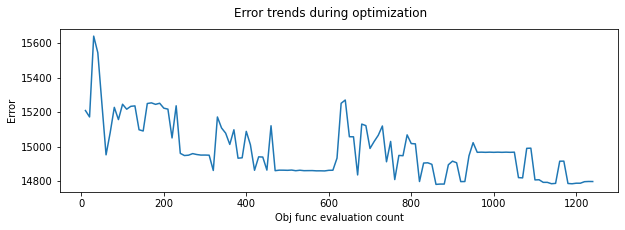

In [9]:
new_Gg, new_Gs = connectomes.compact_to_model_param(res.x, N)
print("The optimized Gg and Gs are:\n%s\n%s\n" % (new_Gg, new_Gs))
print("Old Gg and Gs are:\n%s\n%s\n" % (init_Gg, init_Gs))
print("The difference matrices are:\n%s\n%s\n" % (new_Gg-init_Gg, new_Gs-init_Gs))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(eval_times, errs)
ax.set_xlabel('Obj func evaluation count')
ax.set_ylabel('Error')
fig.suptitle("Error trends during optimization")

# Compare optimized dynamics against golden

Using the default neural parameters
Accepted the custom connectivity
All neurons are healthy
Network integration prep completed...
Computing network dynamics...
Mean error = 30.4251, Summed error  = 15212.5534


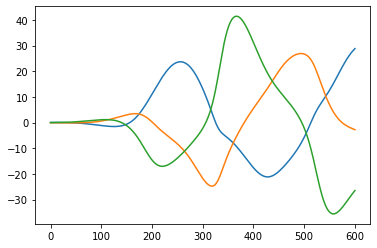

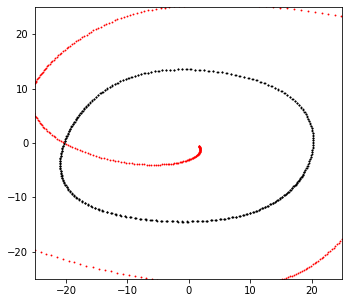

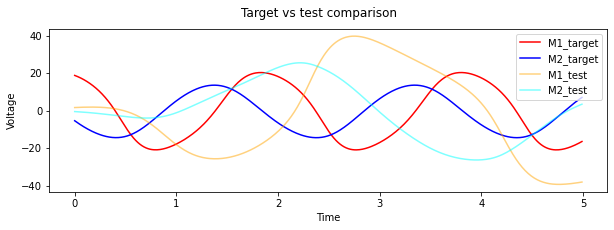

In [12]:
initial_network = connectome_utils.generate_random_network(
  N = problem.N,
  n_inhibitory = 1,
  max_degree = 15)

mean_err, summed_err = rc.utils.compute_problem_score(init_Gg, init_Gs,
                                                        problem, verbose=False)
print("Mean error = %.4f, Summed error  = %.4f" % (mean_err, summed_err))